# Example MLP: Data base Diabetes

In this example it will show how to work the library **deepensemble**. 

## Data

Diabetes patient records were obtained from two sources: an automatic electronic recording device and paper records. The automatic device had an internal clock to timestamp events, whereas the paper records only provided "logical time" slots (breakfast, lunch, dinner, bedtime). For paper records, fixed times were assigned to breakfast (08:00), lunch (12:00), dinner (18:00), and bedtime (22:00). Thus paper records have fictitious uniform recording times whereas electronic records have more realistic time stamps. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from config_test import *

from sklearn import model_selection
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *


data_input, data_target, classes_labels, name_db, desc, col_names = \
    load_data('diabetes_scale', data_home='../../test_models/data', normalize=False)

# Generate testing and training sets
input_train, input_test, target_train, target_test = \
    model_selection.train_test_split(data_input, data_target, test_size=0.3)

## Define parameters of models and training

In [2]:
n_features = data_input.shape[1]
n_classes = len(classes_labels)

n_output = n_classes
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

n_ensemble_models = 4
fn_activation1 = ActivationFunctions.sigmoid
fn_activation2 = ActivationFunctions.sigmoid

y = get_index_label_classes(translate_target(data_target, classes_labels))
s = ITLFunctions.silverman(shared(np.array(y))).eval()

list_scores = [
    {'fun_score': mutual_information_parzen, 'name': 'Mutual Information'},
    {'fun_score': mutual_information_cs, 'name': 'QMI CS'},
    {'fun_score': mutual_information_ed, 'name': 'QMI ED'}
]

print('Silverman: %0.4g' % s)

batch_size = 32
max_epoch = 500

lr = 0.1

update_fn=sgd
name_update='SGD'

args_train_default = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True}

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 0.4689


## Training MLP MSE

This MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [3]:
# Create MLP
mlp = get_mlp_model("MLP MSE",
                    classification=True, classes_labels=classes_labels,
                    n_input=n_features, n_output=n_output,
                    n_neurons=n_neurons_model,
                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                    update=update_fn, name_update=name_update,
                    cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)
# Compile
mlp.compile(fast=True)                    
# training
metrics = mlp.fit(input_train, target_train, **args_train_default)
print("FINISHED!")
# Compute metricstrain
metrics_mlp.append_metric(metrics)

Comienza la compilación MLP MSE  - elapsed: 0.85 [s]
MLP MSE - fold: 1, epoch:[####################] 500/500 elapsed: 3.16[s] - left: 0.00[s] | score: 0.7937 / 0.7812
FINISHED!


<IPython.core.display.Javascript object>


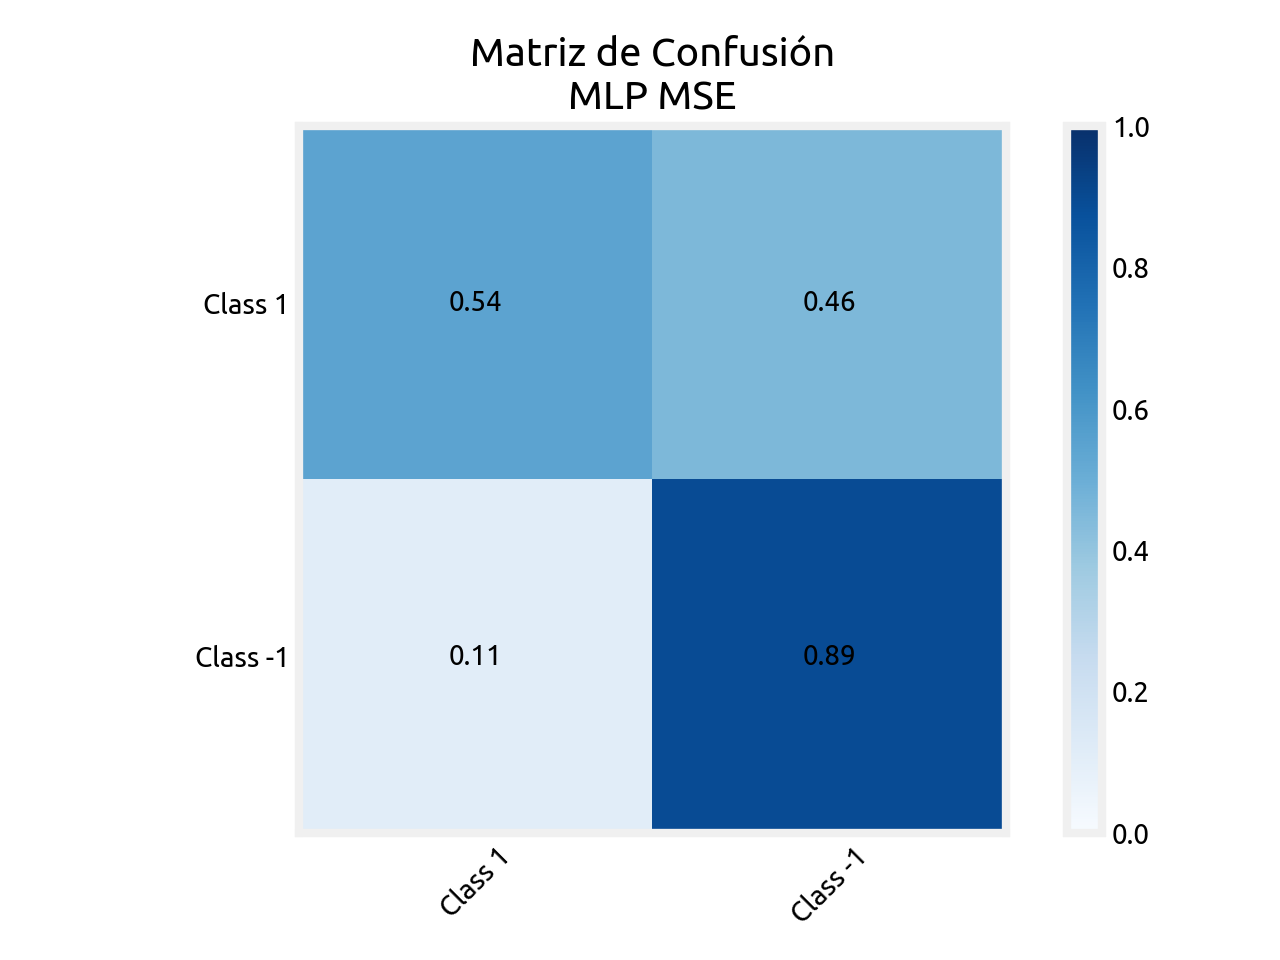

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    76.92 +-0.00      54.35 +-0.00      63.69 +-0.00      92                
Class -1   74.70 +-0.00      89.21 +-0.00      81.31 +-0.00      139               
----------------------------------------------------------------------------
average:   75.58 +-0.00      75.32 +-0.00      74.30 +-0.00      
----------------------------------------------------------------------------



In [4]:
metrics_mlp.append_prediction(input_test, target_test, append_last_pred=True)
metrics_mlp.plot_confusion_matrix(title='Matriz de Confusión\nMLP MSE')
plt.show()

metrics_mlp.classification_report()

## Training Ensemble MSE

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [5]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble MSE', classification=True, classes_labels=classes_labels,
                              n_input=n_features, n_output=n_output,
                              n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                              fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                              cost=mse, name_cost="MSE",
                              update=update_fn, name_update=name_update,
                              params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)
# Compile
ensemble.compile(fast=True)
# training
metrics = ensemble.fit(input_train, target_train, **args_train_default)
print("FINISHED!")
# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Comienza la compilación Ensamble MSE  - elapsed: 2.46 [s]
Ensamble MSE - fold: 1, epoch:[####################] 500/500 elapsed: 9.23[s] - left: 0.00[s] | score: 0.7812 / 0.7812
FINISHED!


<IPython.core.display.Javascript object>


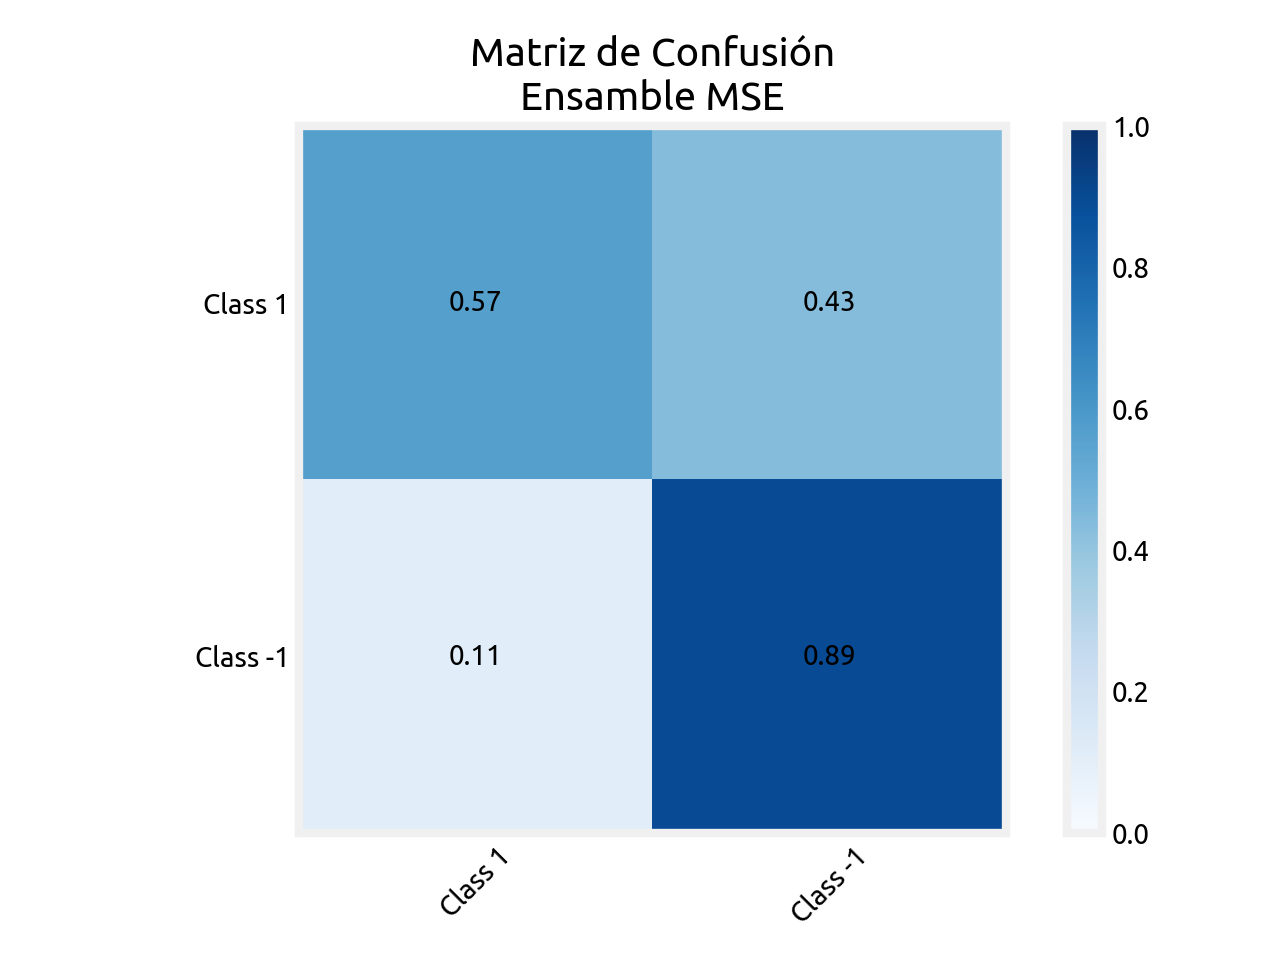

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    77.61 +-0.00      56.52 +-0.00      65.41 +-0.00      92                
Class -1   75.61 +-0.00      89.21 +-0.00      81.85 +-0.00      139               
----------------------------------------------------------------------------
average:   76.41 +-0.00      76.19 +-0.00      75.30 +-0.00      
----------------------------------------------------------------------------



In [6]:
metrics_ensemble.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensemble.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble MSE')
plt.show()

metrics_ensemble.classification_report()

## Training Ensemble NCL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **NCL** (Negative Correlation Learning) and the update funtion is **SGD** (learning rate $\eta=${{lr}}). The parameter of **NCL** is $\lambda=0.3$.

In [7]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL', classification=True, classes_labels=classes_labels,
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        update=update_fn, name_update=name_update,
                                        lamb=0.3, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)
# Compile
ensembleNCL.compile(fast=True)                 
# training
metrics = ensembleNCL.fit(input_train, target_train, **args_train_default)
print("FINISHED!")
# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Comienza la compilación Ensamble NCL  - elapsed: 7.37 [s]
Ensamble NCL - fold: 1, epoch:[####################] 500/500 elapsed: 13.70[s] - left: 0.00[s] | score: 0.7896 / 0.6562
FINISHED!


<IPython.core.display.Javascript object>


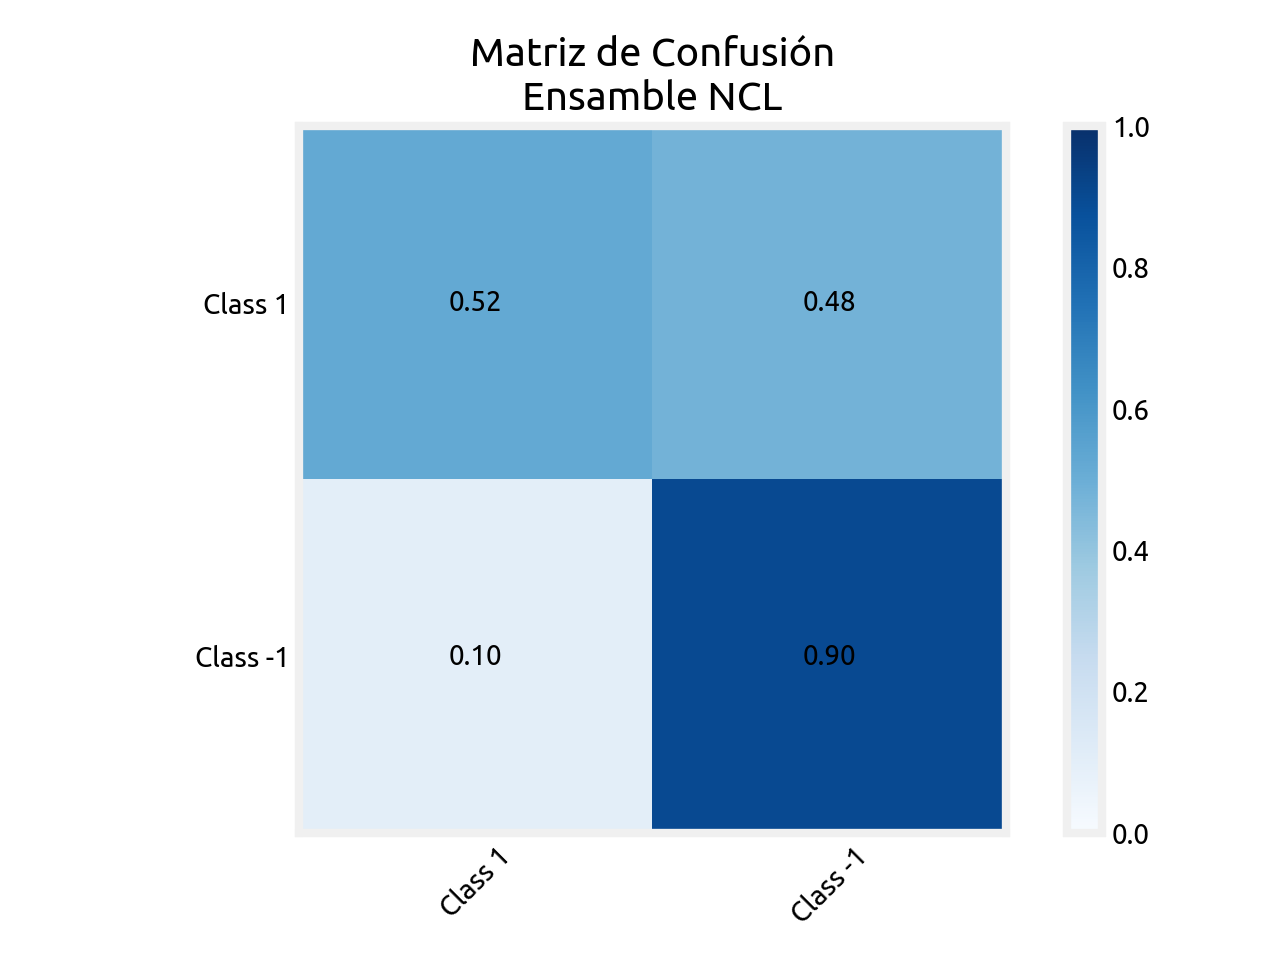

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    77.42 +-0.00      52.17 +-0.00      62.34 +-0.00      92                
Class -1   73.96 +-0.00      89.93 +-0.00      81.17 +-0.00      139               
----------------------------------------------------------------------------
average:   75.34 +-0.00      74.89 +-0.00      73.67 +-0.00      
----------------------------------------------------------------------------



In [8]:
metrics_ensembleNCL.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleNCL.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble NCL')
plt.show()

metrics_ensembleNCL.classification_report()

## Training Ensemble CIPL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **CIPL** (Cross Informartion Potential Learning) and the update funtion is **SGD** (learning rate $\eta=-0.5$). The parameters of **CIPL** are $\beta=0.3$ and $\lambda=0.3$.

In [50]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIPL', classification=True, classes_labels=classes_labels,
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.1, lamb=0.5, s=s,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.003,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=update_fn, name_update=name_update,
                                    params_update={'learning_rate': -0.3})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)
# Compile
ensembleCIP.compile(fast=False)                   
# training
metrics = ensembleCIP.fit(input_train, target_train, **args_train_cip)
print("FINISHED!")
# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIPL  - elapsed: 20.08 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 36.81[s] - left: 0.00[s] | score: 0.4729 / 0.46880
FINISHED!


<IPython.core.display.Javascript object>


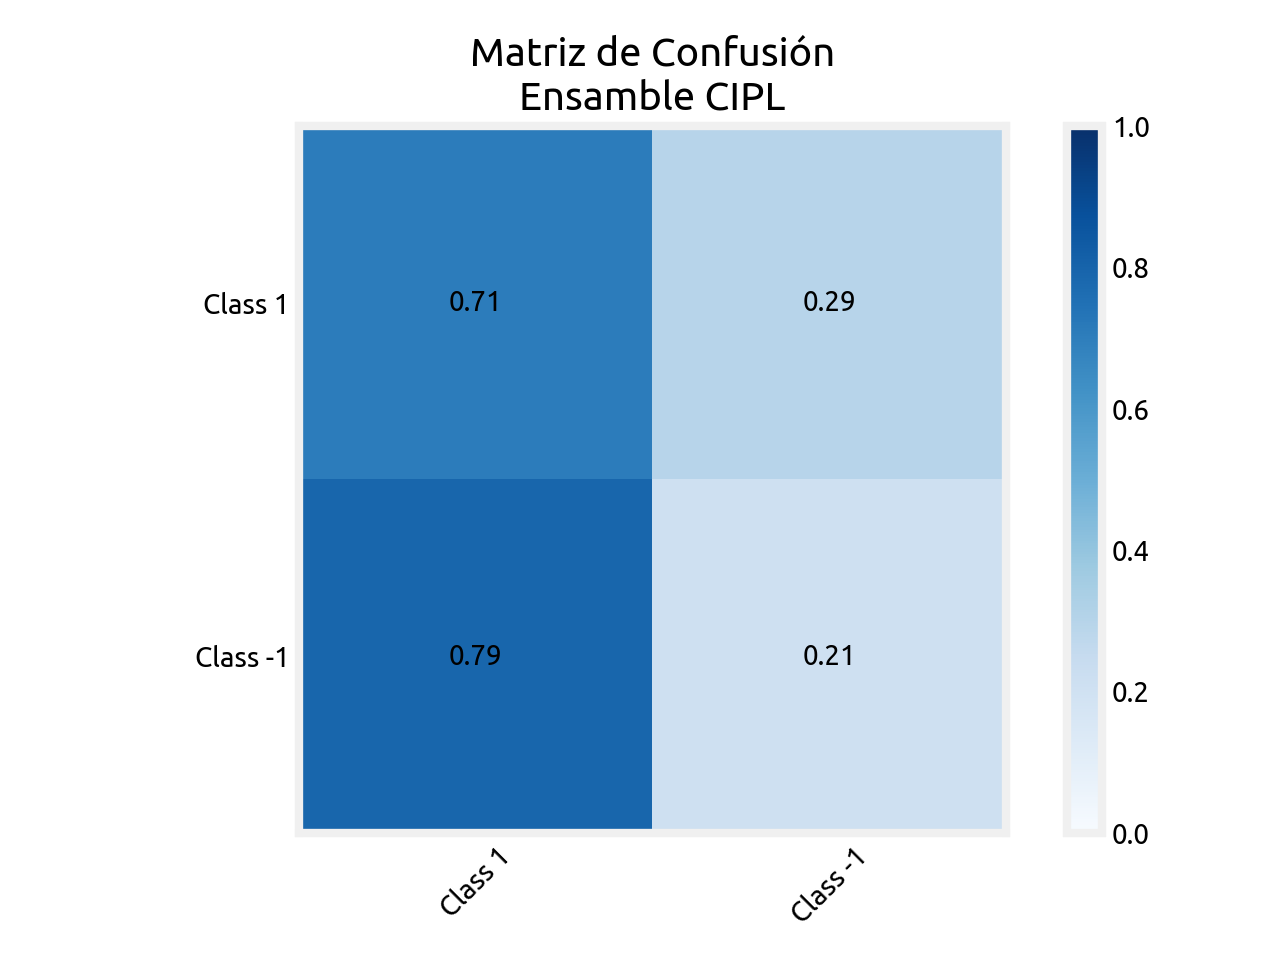

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    37.14 +-0.00      70.65 +-0.00      48.69 +-0.00      92                
Class -1   51.79 +-0.00      20.86 +-0.00      29.74 +-0.00      139               
----------------------------------------------------------------------------
average:   45.95 +-0.00      40.69 +-0.00      37.29 +-0.00      
----------------------------------------------------------------------------



In [51]:
metrics_ensembleCIP.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleCIP.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble CIPL')
plt.show()

metrics_ensembleCIP.classification_report()

## Plot Scores ans cost functions of Ensemble CIPL training

<IPython.core.display.Javascript object>


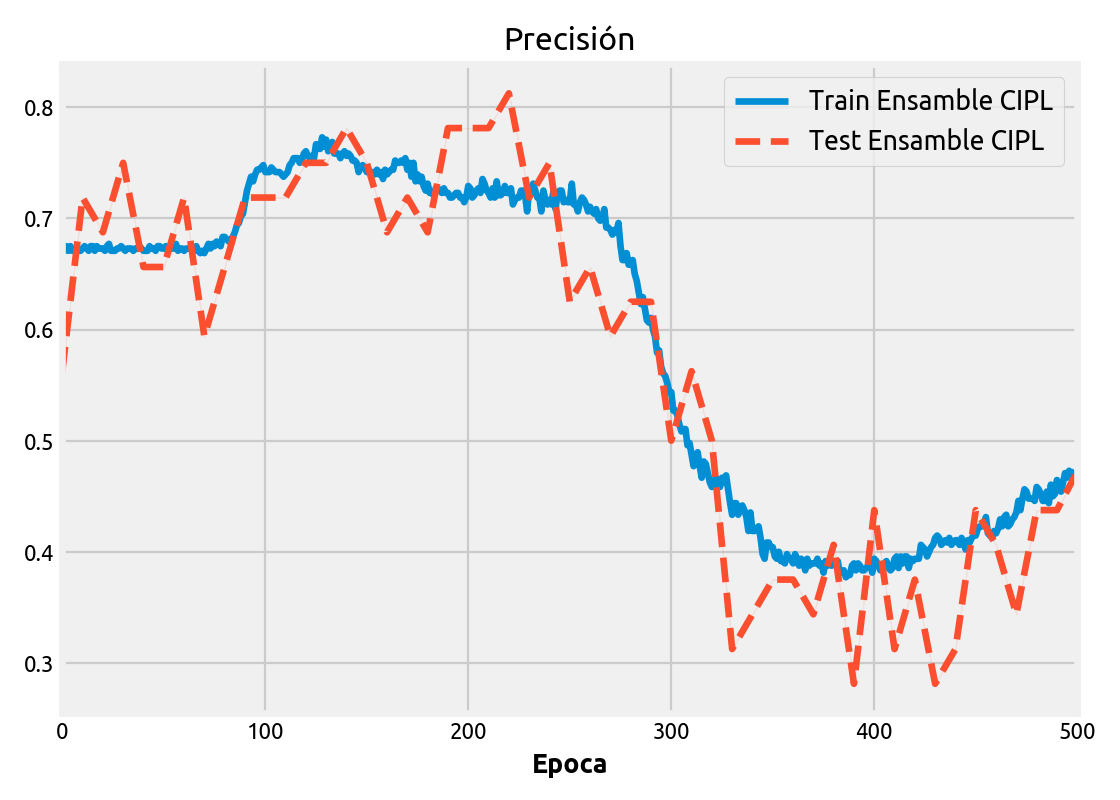

<IPython.core.display.Javascript object>


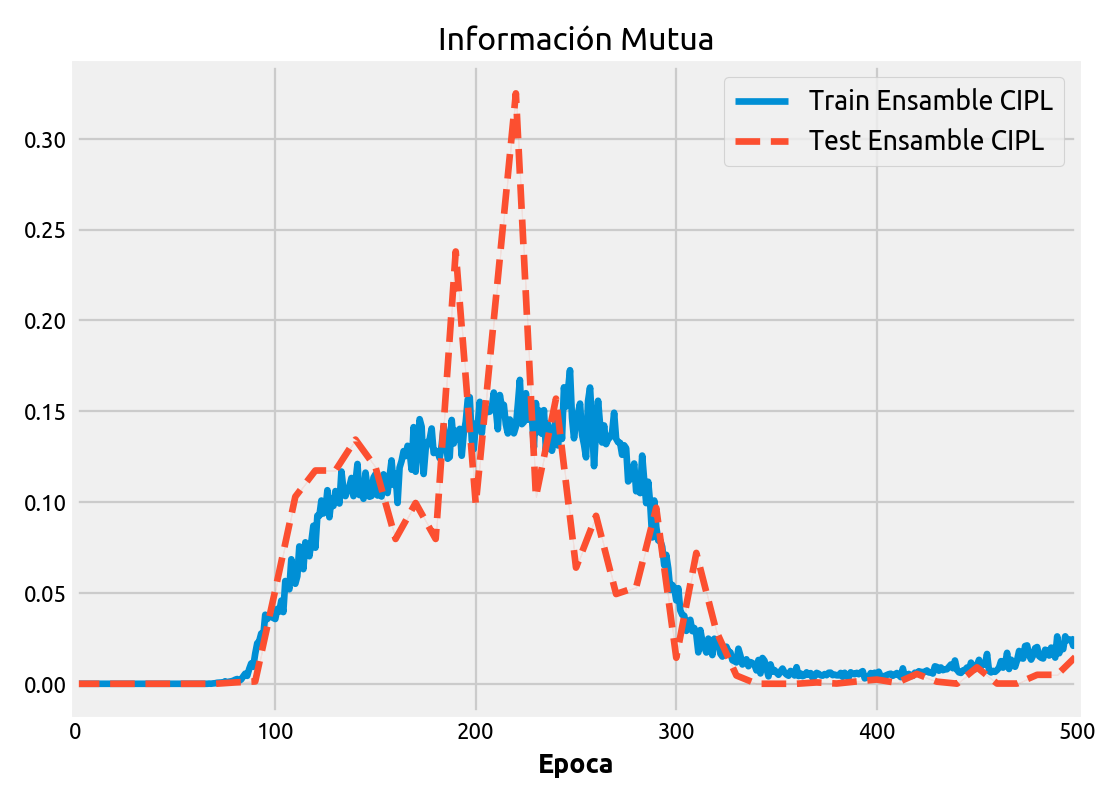

<IPython.core.display.Javascript object>


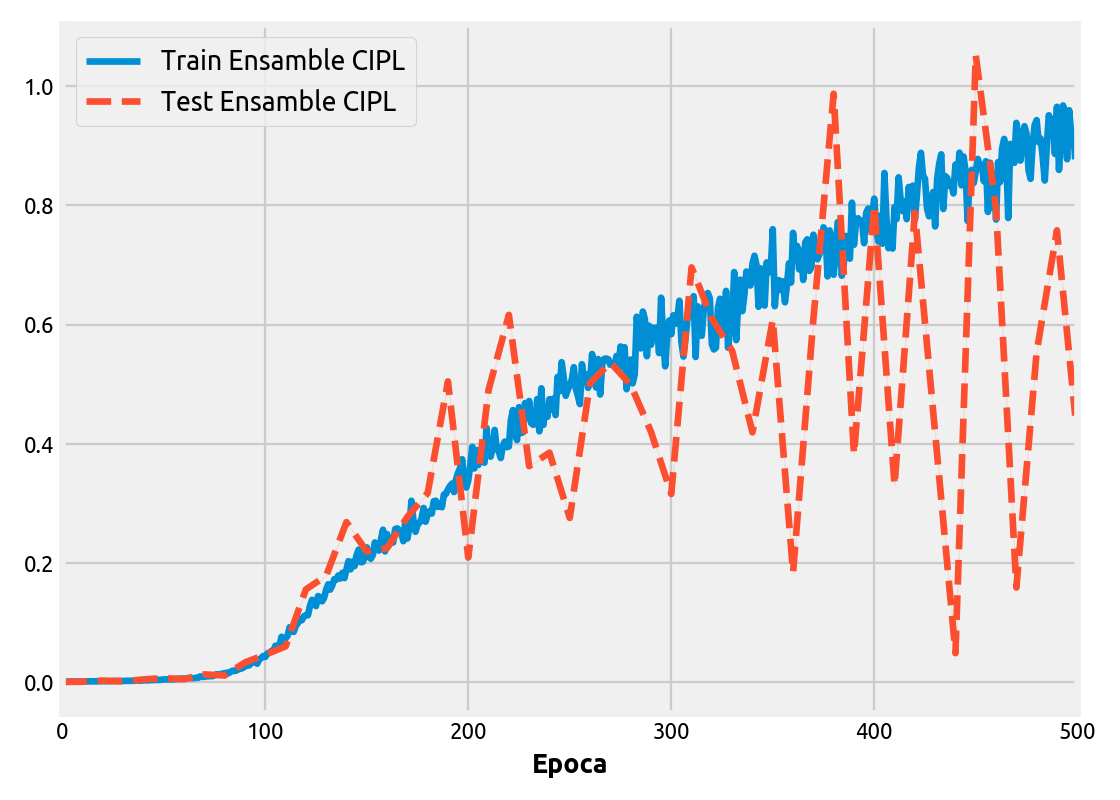

In [52]:
metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')
metrics_ensembleCIP.plot_cost(max_epoch=max_epoch, title='')

plt.show()

## Summary training

In [53]:
score_test_ensemble = ensemble.score(input_test, target_test)
score_train_ensemble = ensemble.score(input_train, target_train)

score_test_ensembleNCL = ensembleNCL.score(input_test, target_test)
score_train_ensembleNCL = ensembleNCL.score(input_train, target_train)

score_test_ensembleCIP = ensembleCIP.score(input_test, target_test)
score_train_ensembleCIP = ensembleCIP.score(input_train, target_train)

score_test_mlp = mlp.score(input_test, target_test)
score_train_mlp = mlp.score(input_train, target_train)

print('Score Precisión')
print('Ensamble MSE: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP MSE: %f / %f' % (score_train_mlp, score_test_mlp))

Score Precisión
Ensamble MSE: 0.780261 / 0.761905
Ensamble NCL: 0.780261 / 0.748918
Ensamble CIP: 0.381750 / 0.406926
MLP MSE: 0.782123 / 0.753247


## Plot PDF Error for each model training

### Training set

<IPython.core.display.Javascript object>


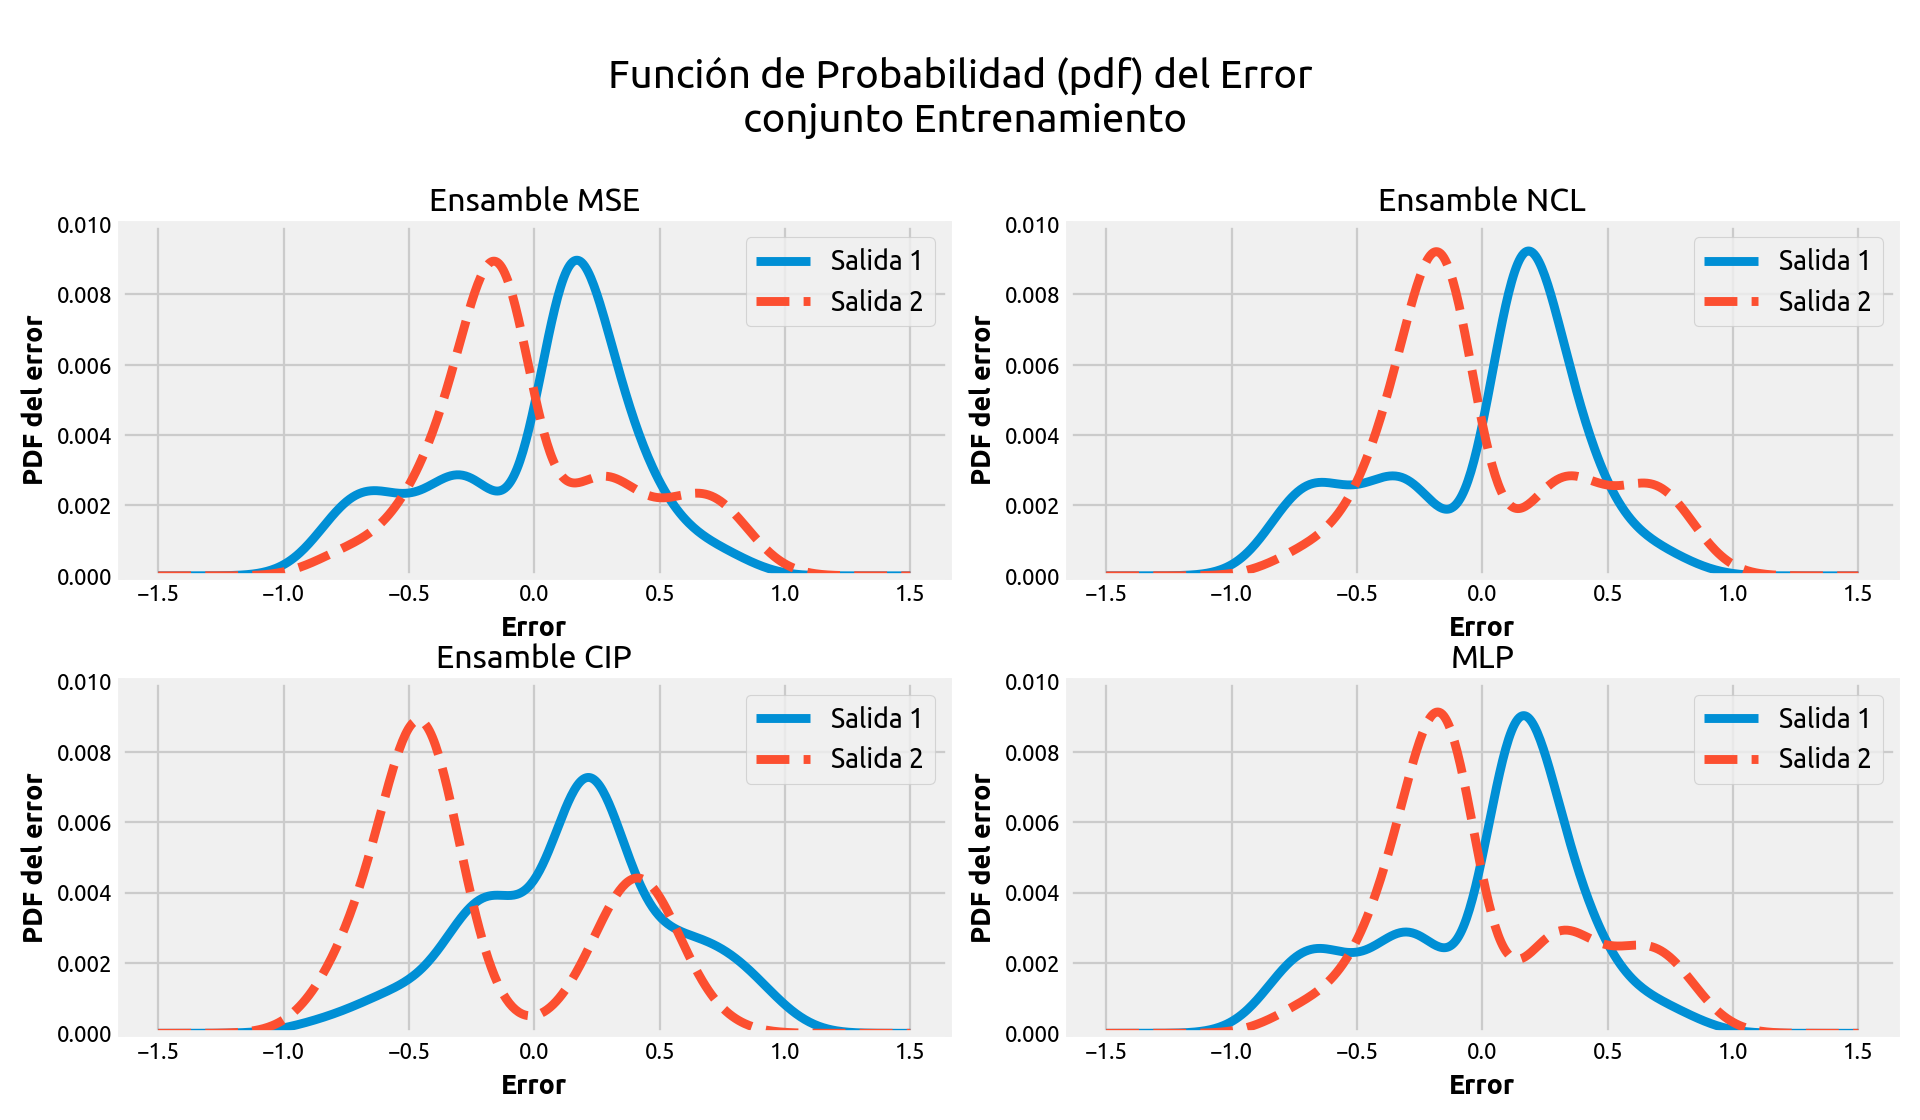

In [54]:
fig = plt.figure(figsize=(12, 7), dpi=80)
lim_y = 0.01

ax = fig.add_subplot(2, 2, 1)
plot_pdf_error(ensemble, input_train, target_train, 'Ensamble MSE', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 2)
plot_pdf_error(ensembleNCL, input_train, target_train, 'Ensamble NCL', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 3)
plot_pdf_error(ensembleCIP, input_train, target_train, 'Ensamble CIP', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 4)
plot_pdf_error(mlp, input_train, target_train, 'MLP', ax, fig, lim_y=lim_y)

st = fig.suptitle("Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento", fontsize=18)

st.set_y(0.95)
fig.subplots_adjust(top=0.8)


### Test set

<IPython.core.display.Javascript object>


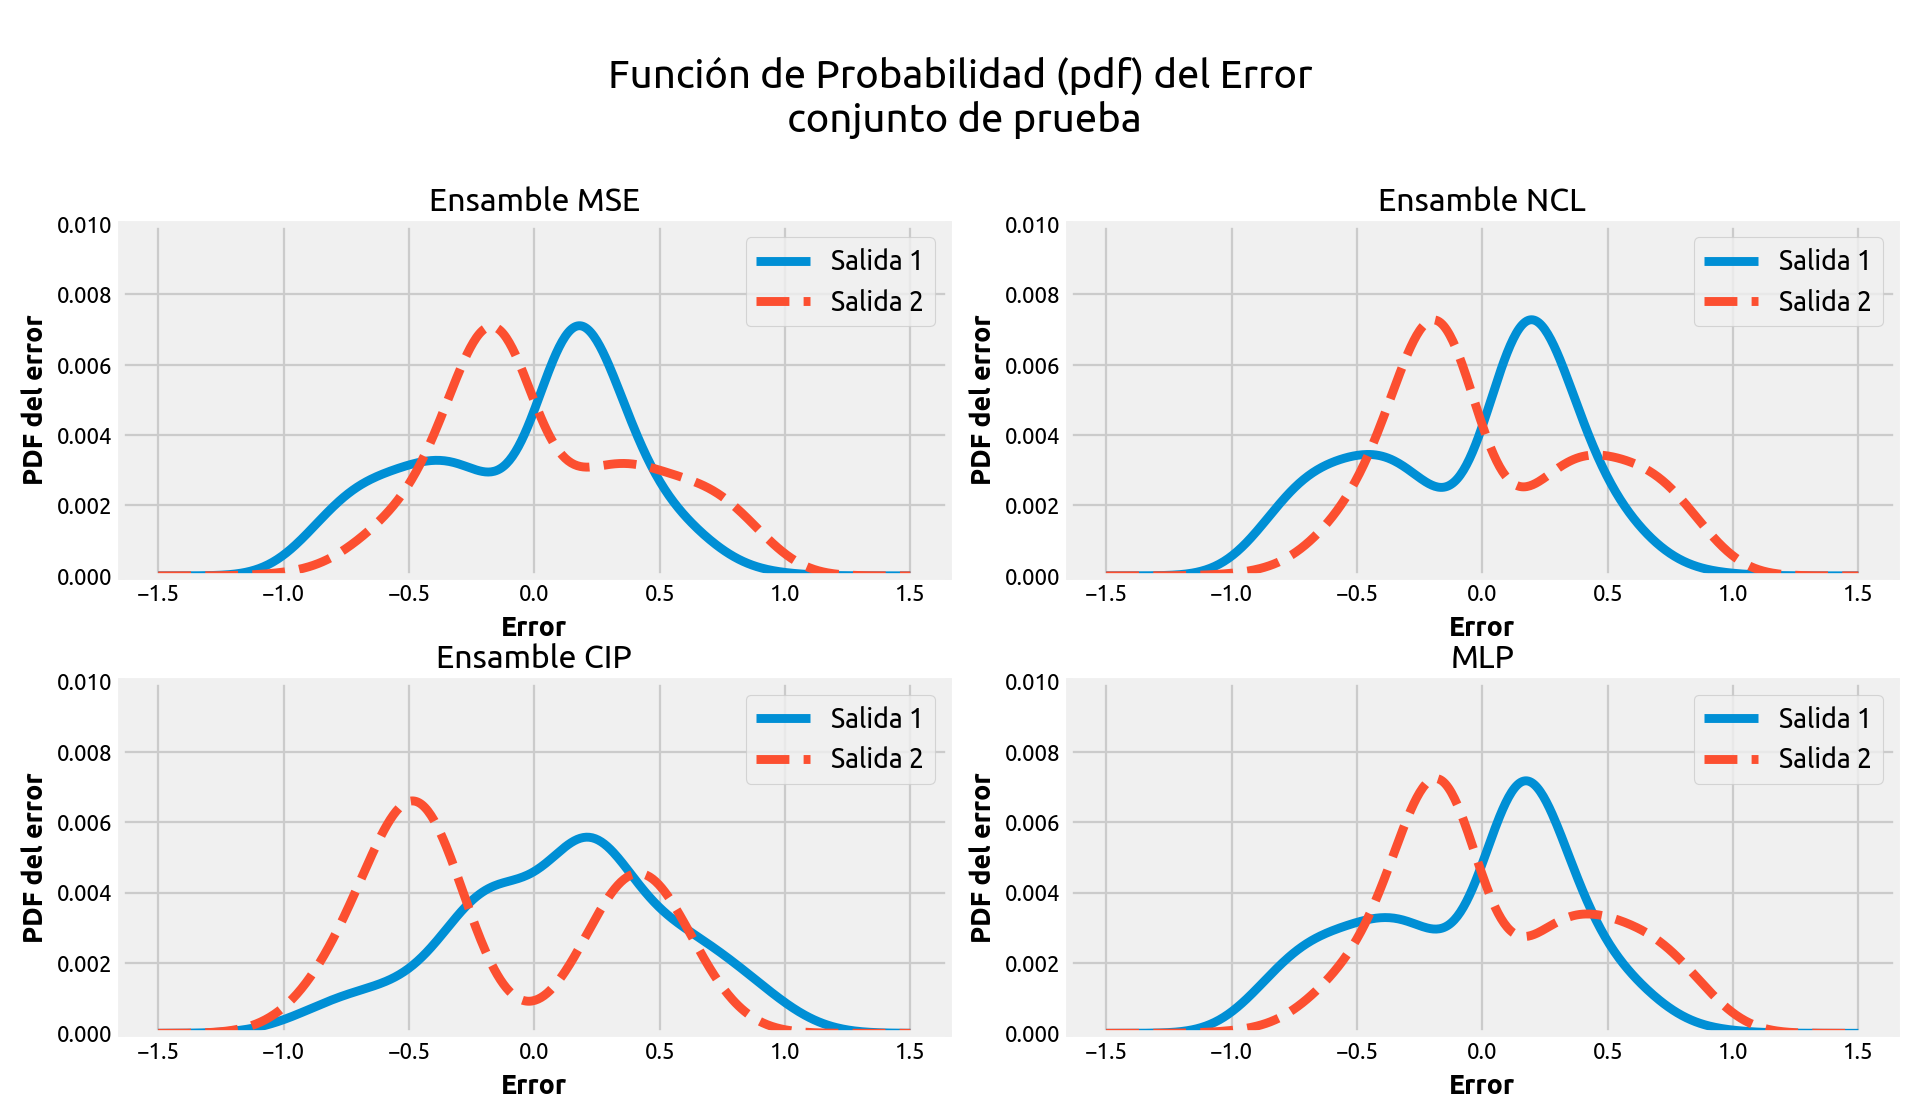

In [55]:
fig = plt.figure(figsize=(12, 7), dpi=80)

ax = fig.add_subplot(2, 2, 1)
plot_pdf_error(ensemble, input_test, target_test, 'Ensamble MSE', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 2)
plot_pdf_error(ensembleNCL, input_test, target_test, 'Ensamble NCL', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 3)
plot_pdf_error(ensembleCIP, input_test, target_test, 'Ensamble CIP', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 4)
plot_pdf_error(mlp, input_test, target_test, 'MLP', ax, fig, lim_y=lim_y)

st = fig.suptitle("Función de Probabilidad (pdf) del Error\n conjunto de prueba", fontsize=18)

st.set_y(0.95)
fig.subplots_adjust(top=0.8)

plt.show()

## Test: Prediction with noise in input data

In [15]:
def get_ensemble_cip_cs(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.1,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.2}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_ed(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lsp=1.5, lsm=0.1,
                                    lr=0.1,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.2}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [16]:
noise = [n for n in np.linspace(0.01, 1, 10)]
score_snr_cs = []
score_snr_ed = []
score_snr_ncl = []
score_snr_en = []
score_snr_mlp = []
SNR = []
N = input_test.shape[0]
F = input_test.shape[1]
mu = 0.2

model_cs = get_ensemble_cip_cs(0.5, s)
model_cs.fit(input_train, target_train, **args_train_cip)

model_ed = get_ensemble_cip_ed(0.5, s)
model_ed.fit(input_train, target_train, **args_train_cip)

for n in noise:
    ne = np.random.randn(N, F) * n + mu
    z = input_test + ne
    score_snr_cs.append(model_cs.score(z, target_test))
    score_snr_ed.append(model_ed.score(z, target_test))
    score_snr_ncl.append(ensembleNCL.score(z, target_test))
    score_snr_en.append(ensemble.score(z, target_test))
    score_snr_mlp.append(mlp.score(z, target_test))
    SNR.append(np.var(input_test) / np.var(ne))

Comienza la compilación Ensamble CIPL CS  - elapsed: 28.16 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 41.67[s] - left: 0.00[s] | score: 0.7833 / 0.59385
Comienza la compilación Ensamble CIPL ED  - elapsed: 25.59 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 40.65[s] - left: 0.00[s] | score: 0.7479 / 0.75005


<IPython.core.display.Javascript object>


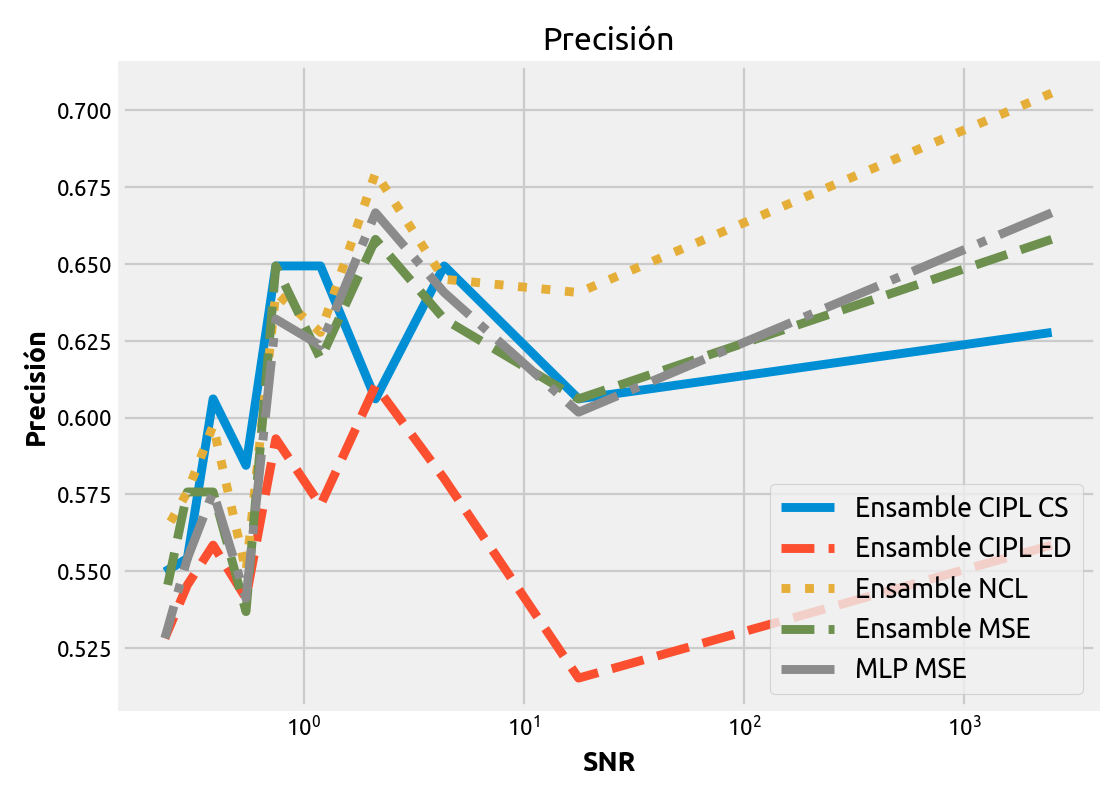

In [17]:
f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(SNR, score_snr_cs, linestyle='-', label='Ensamble CIPL CS')
plt.plot(SNR, score_snr_ed, linestyle='--', label='Ensamble CIPL ED')
plt.plot(SNR, score_snr_ncl, linestyle=':', label='Ensamble NCL')
plt.plot(SNR, score_snr_en, linestyle='--', label='Ensamble MSE')
plt.plot(SNR, score_snr_mlp, linestyle='-.', label='MLP MSE')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Precisión')
plt.xlabel('SNR')
plt.ylabel('Precisión')
plt.tight_layout()

plt.show()

## Test: Diversity of Ensemble CIPL when changes parameters $\beta$ and $\lambda$.

In this test is used CIPL with Cauchy-Schwarz and Euclidean divergency. The diversity is measured with:

- Kohavi wolpert Variance.
- Generalized Diversity.
- Coincident Failure.
- Entropy sk.
- Difficulty.

In [18]:
parameters = [n for n in np.linspace(-1, 1, 21)]

score_cs = []
diversity_cs = []
for p in parameters:
    model_cs = get_ensemble_cip_cs(p, s)
    metric = model_cs.fit(input_train, target_train, **args_train_cip)
    score_cs.append(model_cs.score(input_test, target_test))
    metric.append_prediction(input_test, target_test, append_last_pred=True)
    diversity_cs.append(
        (metric.get_diversity(metric=kohavi_wolpert_variance),
         metric.get_diversity(metric=generalized_diversity),
         metric.get_diversity(metric=coincident_failure),
         metric.get_diversity(metric=entropy_sk),
         metric.get_diversity(metric=difficulty),
        ))

Comienza la compilación Ensamble CIPL CS  - elapsed: 27.94 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 42.77[s] - left: 0.00[s] | score: 0.6729 / 0.62508
Comienza la compilación Ensamble CIPL CS  - elapsed: 26.40 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 42.71[s] - left: 0.00[s] | score: 0.6750 / 0.68758
Comienza la compilación Ensamble CIPL CS  - elapsed: 30.10 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 43.46[s] - left: 0.00[s] | score: 0.6750 / 0.84385
Comienza la compilación Ensamble CIPL CS  - elapsed: 28.12 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 44.48[s] - left: 0.00[s] | score: 0.6750 / 0.53128
Comienza la compilación Ensamble CIPL CS  - elapsed: 27.97 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 44.22[s] - left: 0.00[s] | score: 0.6750 / 0.62508
Comienza la compilación Ensamble CIPL CS  - elapsed: 31.64 [

In [19]:
score_ed = []
diversity_ed = []
for p in parameters:
    model_ed = get_ensemble_cip_ed(p, s)
    metric = model_ed.fit(input_train, target_train, **args_train_cip)
    score_ed.append(model_ed.score(input_test, target_test))
    metric.append_prediction(input_test, target_test, append_last_pred=True)
    diversity_ed.append(
        (metric.get_diversity(metric=kohavi_wolpert_variance),
         metric.get_diversity(metric=generalized_diversity),
         metric.get_diversity(metric=coincident_failure),
         metric.get_diversity(metric=entropy_sk),
         metric.get_diversity(metric=difficulty),
        ))

Comienza la compilación Ensamble CIPL ED  - elapsed: 24.13 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 41.70[s] - left: 0.00[s] | score: 0.7500 / 0.68755
Comienza la compilación Ensamble CIPL ED  - elapsed: 27.90 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 40.99[s] - left: 0.00[s] | score: 0.7354 / 0.62508
Comienza la compilación Ensamble CIPL ED  - elapsed: 24.37 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 40.32[s] - left: 0.00[s] | score: 0.7417 / 0.68750
Comienza la compilación Ensamble CIPL ED  - elapsed: 25.03 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 40.80[s] - left: 0.00[s] | score: 0.7396 / 0.71888
Comienza la compilación Ensamble CIPL ED  - elapsed: 24.79 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 40.98[s] - left: 0.00[s] | score: 0.7229 / 0.68750
Comienza la compilación Ensamble CIPL ED  - elapsed: 27.05 [

<IPython.core.display.Javascript object>


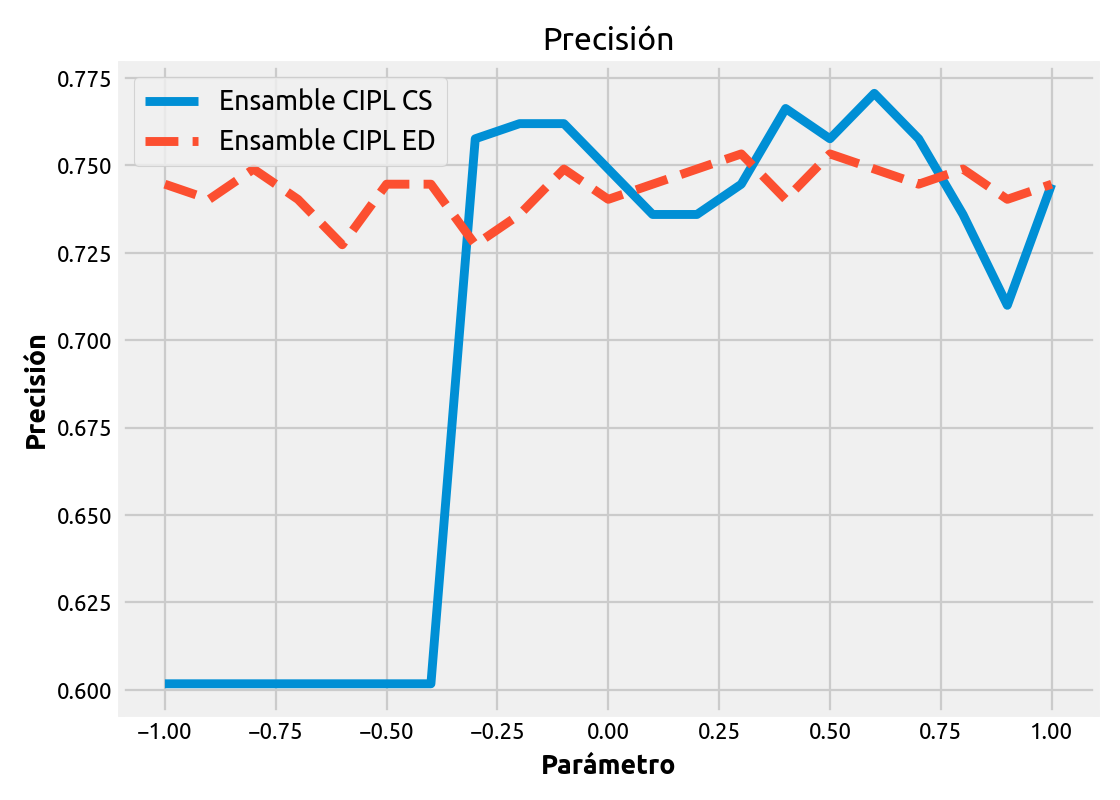

<IPython.core.display.Javascript object>


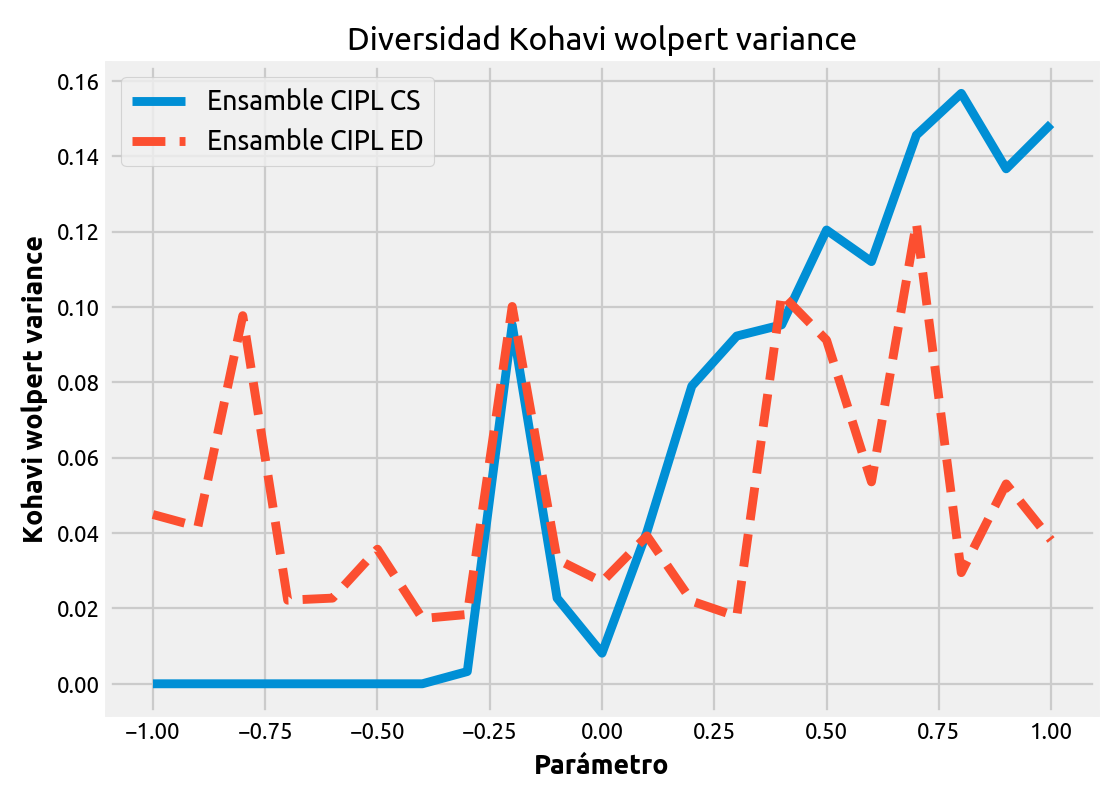

<IPython.core.display.Javascript object>


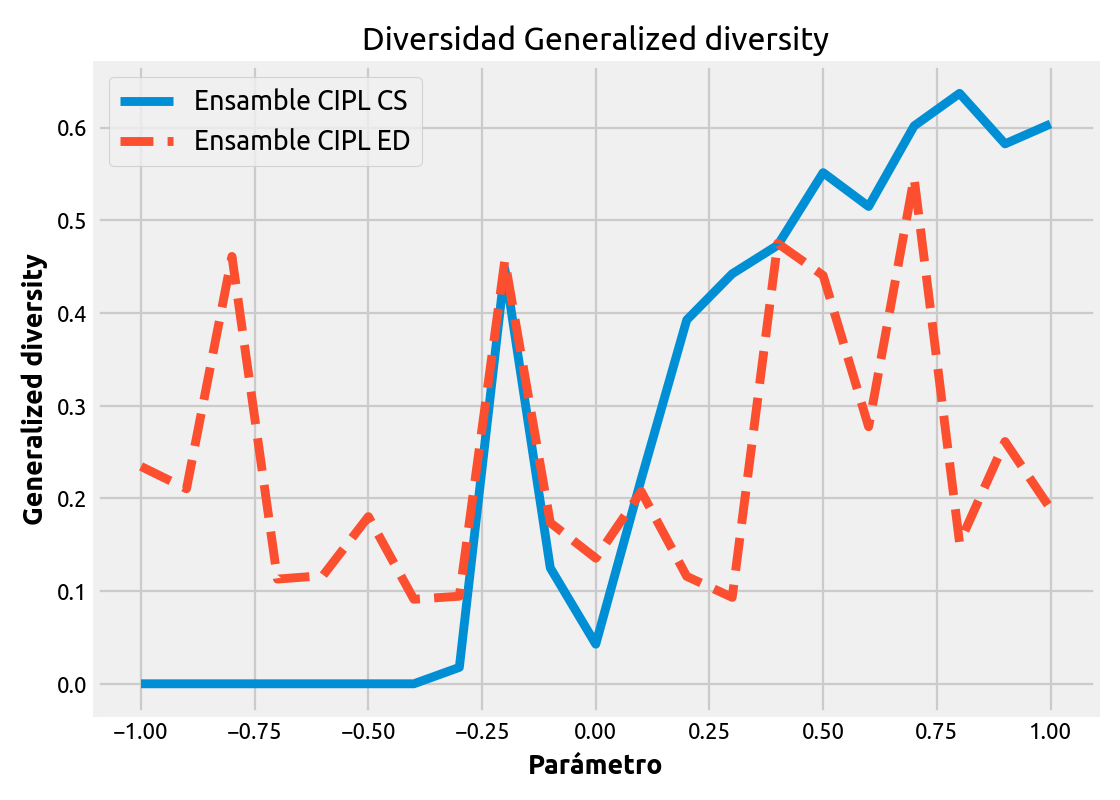

<IPython.core.display.Javascript object>


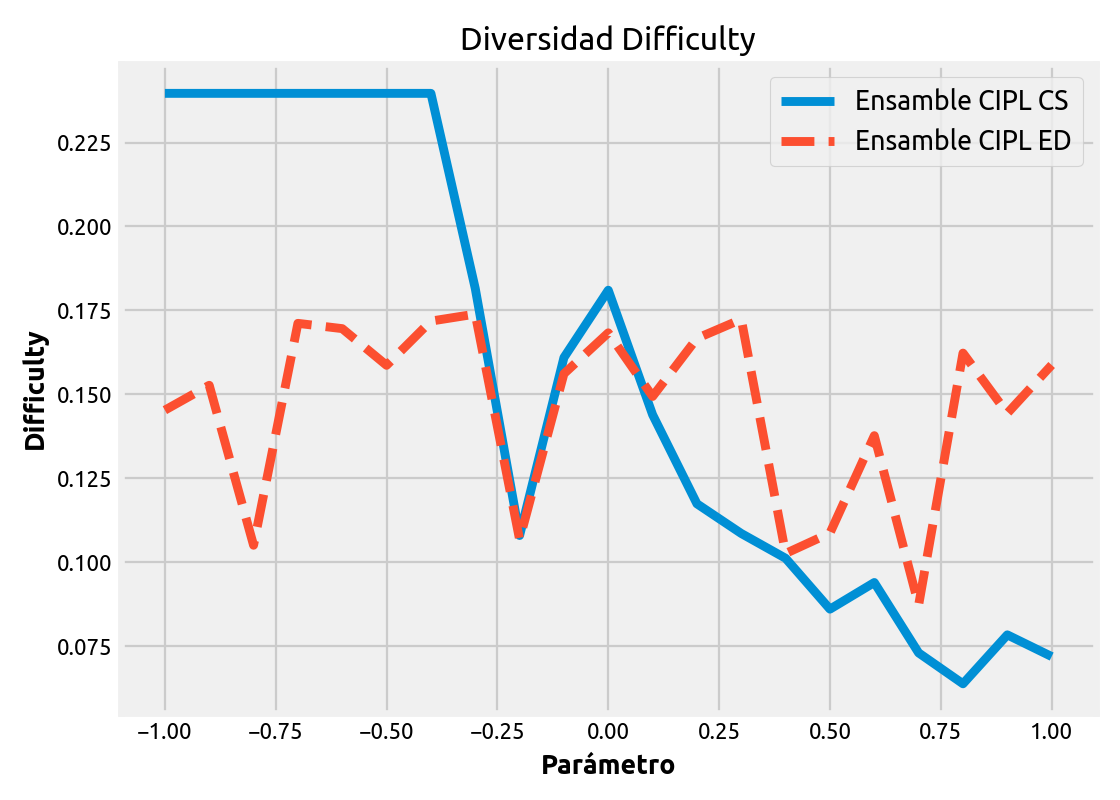

In [20]:
score_cs = np.array(score_cs)
diversity_cs = np.array(diversity_cs)
score_ed = np.array(score_ed)
diversity_ed = np.array(diversity_ed)

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, score_cs, linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, score_ed, linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Precisión')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')
plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:,0, 0], linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, diversity_ed[:,0, 0], linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Diversidad Kohavi wolpert variance')
plt.xlabel('Parámetro')
plt.ylabel('Kohavi wolpert variance')
plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:,1, 0], linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, diversity_ed[:,1, 0], linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Diversidad Generalized diversity')
plt.xlabel('Parámetro')
plt.ylabel('Generalized diversity')
plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:,4, 0], linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, diversity_ed[:,4, 0], linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Diversidad Difficulty')
plt.xlabel('Parámetro')
plt.ylabel('Difficulty')
plt.tight_layout()

plt.show()